In [4]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, Ridge, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostRegressor,  BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor


from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import altair as alt
import datetime as dt

In [5]:
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf  # for data
from pandas_datareader import data as pdr
yf.pdr_override()

In [6]:
def read_data(stock='TSLA', period = "360d", interval = "1d"):
    '''
    reading the data
    '''


    df = pdr.get_data_yahoo(stock,period = period,

            # fetch data by interval (including intraday if period < 60 days)
            # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
            # (optional, default is '1d')
            interval = interval,)


    return df

In [7]:
df = read_data(stock='TSLA').reset_index()

[*********************100%***********************]  1 of 1 completed


In [6]:
# here is the tail of the df which has the most recent data
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
355,2020-11-03,409.730011,427.769989,406.690002,423.899994,423.899994,34351700
356,2020-11-04,430.619995,435.399994,417.100006,420.980011,420.980011,32143100
357,2020-11-05,428.299988,440.000000,424.000000,438.089996,438.089996,28414500
358,2020-11-06,436.100006,436.570007,424.279999,429.950012,429.950012,21653600
359,2020-11-09,439.500000,452.500000,431.709991,437.760010,437.760010,22086023


### Feature Engineering:

- The idea is to create a useful set of features for the model. For stock price prediction, we are trying to predict the price of stock in the next timestep given it's current price and also the history of the prices that we have. We also have the volume that was traded at each time step. But we have to note here that we don't have the volume of the current trade but we have the volume at the previous step. So we are trying to use this lagged information as out innputs. Additionally we can create new feartures, by applying technical analysis. For example calculating the simple moving average, ballinger bands which we we will include in this analysis, macd, etc.

- First let's start with the lagged information, we will shift the high, low, and volume columns one row, which is equivelant to use the previous time steps information which is know for predicting the price. For the open price we don't need to do that because it's just the price at the start of this time step which is know. 


In [8]:
df['High'] = df['High'].shift(1)
df['Low'] = df['Low'].shift(1)
df['Volume'] = df['Volume'].shift(1)

In [9]:
# we will also convert the datetime columns to be ordinal as our model can not process datetime data

In [11]:
# df['Datetime'] = pd.to_datetime(df['Datetime'])
# df['Datetime']=df['Datetime'].map(dt.datetime.toordinal)

In [279]:
# now we will calculate a bunch of technical indicators, sma and ballinger bands, additionally we will create two additional columns , status lower and status upper which we will serve as 
# indicators if the price crossed below the ballinger lower band or above the ballinger band
df['SMA'] = df['Adj Close'].rolling(window = 20).mean()
df['Middle Band'] =df['Adj Close'].rolling(window=20).mean()
df['Upper Band'] = df['Middle Band'] + 1.96*df['Adj Close'].rolling(window=20).std()
df['Lower Band'] = df['Middle Band'] - 1.96*df['Adj Close'].rolling(window=20).std()
df['status_lower'] = np.where(df['Adj Close'] < df['Lower Band'],'below_ballinger','normal')
df['status_upper'] = np.where(df['Adj Close'] > df['Upper Band'],'above_ballinger','normal')

In [280]:
# now we will drop na, we will have many of those due to the way SMA is calculated. Also we will drop the close column since we are only using the adj close price columns. This will be the
# the column that we are trying to predict, y. Finally we will create our X using all the columns except, adj close, low and high price

In [281]:
df = df.dropna()
df = df.drop(columns = ['Close'])
y = df['Adj Close']
X = df.drop(columns =['Adj Close','Volume' ,'Low','High'] )

In [282]:
# now let's split the data into train and test set

In [283]:
X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle= False) 

In [284]:
# a quick look athe X_train
X_train

,Datetime,Open,SMA,Middle Band,Upper Band,Lower Band,status_lower,status_upper
19,737726,410.149994,411.393298,411.393298,415.958382,406.828215,normal,normal
20,737726,411.292603,411.046448,411.046448,414.710346,407.382550,normal,normal
21,737726,410.339996,410.990588,410.990588,414.597767,407.383410,normal,normal
22,737726,411.390015,410.815738,410.815738,414.068709,407.562767,normal,normal
23,737726,410.929993,410.609239,410.609239,413.517268,407.701210,normal,normal
...,...,...,...,...,...,...,...,...
967,737732,422.471985,422.900832,422.900832,424.561710,421.239953,normal,normal
968,737732,422.500000,422.858751,422.858751,424.522597,421.194905,normal,normal
969,737732,422.390015,422.883391,422.883391,424.567624,421.199158,normal,normal
970,737732,423.410004,422.842522,422.842522,424.415290,421.269753,normal,normal


In [147]:
# first let's look at the data head
df['f01'] = df['Close']/df['Open']-1
df['f01']

0     -0.009309
1     -0.061404
2      0.016779
3      0.017373
4      0.044320
         ...   
355   -0.022386
356    0.022858
357   -0.014102
358   -0.041502
359   -0.023162
Name: f01, Length: 360, dtype: float64

In [ ]:
### Modeling

In [211]:
# first transformer for the numeric features
numeric_features = list(set(list(X_train.columns)) - set(['status_lower','status_upper']))
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
   ])
# now a taransformer for the categorical features
categorical_features = ['status_lower','status_upper']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
# creating a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

ridge_model = Ridge()
# include the preprocessor and the model in one pipeline.
# Now we have a full prediction pipeline.
reg_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('Regressor', ridge_model)])

# finally we will pass the pipe line to gridsearchcv to find the optimum paramters for the model
param_grid = {
    'Regressor__alpha':[0.1,0.25,0.4],
}
search = GridSearchCV(reg_pipeline,param_grid,cv = 5)

# fitting the model
search.fit(X_train, y_train)

# printing the first parameter
print(search.best_params_)
print("model score: %.3f" % search.score(X_test, y_test))

{'Regressor__alpha': 0.1}
model score: 0.925


In [ ]:
# let's check the prediction of the model, we are specifically interested in the last raw which has the most recent data, and we want to see the prediction of the close price for that time step

In [228]:
y_pred = search.predict(X_test)
y_pred[-1]

429.46199040624674

In [229]:
### Model Evaluation

In [231]:
np.sqrt(mean_squared_error(y_test,y_pred))

1.4387108372940598

In [232]:
# how the actual and predicted prices are correlated

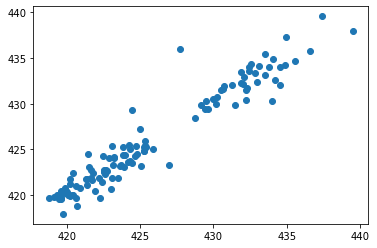

In [233]:
plt.scatter(y_test,y_pred);

In [234]:
X_test['actual'] = y_test
X_test['pred'] = y_pred

In [235]:
X_test

,Datetime,Open,Volume,SMA,Middle Band,Upper Band,Lower Band,status_lower,status_upper,actual,pred
384,737732,422.640015,322692.0,423.052052,423.052052,425.797445,420.306660,normal,normal,422.690002,422.750531
385,737732,422.690002,314357.0,423.088048,423.088048,425.735737,420.440359,normal,normal,421.619995,422.799092
386,737732,421.769989,307561.0,423.112048,423.112048,425.697796,420.526301,normal,normal,421.670013,421.881103
387,737732,421.725006,412024.0,423.278838,423.278838,425.468150,421.089525,normal,normal,423.459991,421.924252
388,737732,423.410004,397009.0,423.398587,423.398587,425.513371,421.283804,normal,normal,424.204987,423.595683
...,...,...,...,...,...,...,...,...,...,...,...
501,737734,431.500000,146640.0,432.113467,432.113467,434.892717,429.334218,normal,normal,430.519501,431.535358
502,737734,430.489197,127995.0,432.018967,432.018967,434.948326,429.089607,normal,normal,430.000000,430.509430
503,737734,429.900085,221544.0,431.912967,431.912967,434.946696,428.879238,normal,normal,430.179993,429.980789
504,737734,430.279999,147008.0,431.662971,431.662971,434.625219,428.700724,normal,normal,429.500000,430.311807


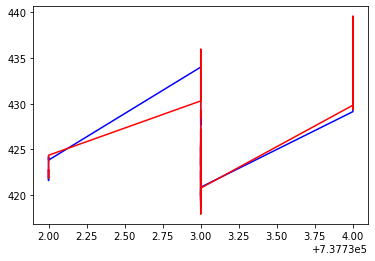

In [236]:
# finally let's plot the actual and predicted price with time
plt.plot(X_test['Datetime'],X_test['actual'],'b')
plt.plot(X_test['Datetime'],X_test['pred'],'r')

In [ ]:
# let's create a funciton to do all this steps for us:

In [65]:
def test_stock(stock, intra = True, period = "7d", interval = "1m"):
    """
    predict the price for the closing price for the bext inerval. 
    
    inputs:
    ------
    - stock: string, symobol for the stick, eg. 'TSLA'
    - intra : Boolean, if True then the period and interval should be 1m, 5m, etc, if False it should be 1d, 7d, etc
    - period : total period
    - interval : interval for the data
    
    """

    
    if intra ==True:
        
            df = read_data(stock=stock, period = period, interval = interval).reset_index()
            df_nasaq = read_data(stock='NDAQ', period = period, interval = interval).reset_index()[['Datetime','Open']]
            df_nasaq.columns = ['Datetime','NASAQ']
            df = pd.merge(df,df_nasaq,on = ['Datetime'], how = 'left')
            #df['f01'] = df['Close']/df['Open']-1




            #print(len(df))
            print(df['Datetime'])
            old = df.tail(1).loc[:,'Open'].to_numpy()[0]
            df['Datetime'] = pd.to_datetime(df['Datetime'])
            df['Datetime']=df['Datetime'].map(dt.datetime.toordinal)
            df['SMA_1'] = df['Adj Close'].rolling(window = 26).mean()
            df['SMA_2'] = df['Adj Close'].rolling(window = 50).mean()
            df['status_sma_lower'] = np.where(df['Adj Close'] < df['SMA_1'],1,0)
            df['status_sma_upper'] = np.where(df['Adj Close'] > df['SMA_2'],1,0)
    

    elif intra ==False:
            df = read_data(stock=stock, period = period, interval = interval).reset_index()
            df_nasaq = read_data(stock='NDAQ', period = period, interval = interval).reset_index()[['Date','Open']]
            df_nasaq.columns = ['Date','NASAQ']
            df = pd.merge(df,df_nasaq,on = ['Date'], how = 'left')
            #df['f01'] = df['Close']/df['Open']-1




            #print(len(df))
            old = df.tail(1).loc[:,'Open'].to_numpy()[0]
            df['Date'] = pd.to_datetime(df['Date'])
            df['Date']=df['Date'].map(dt.datetime.toordinal)
#             df['SMA_1'] = df['Adj Close'].rolling(window = 50).mean()
#             df['SMA_2'] = df['Adj Close'].rolling(window = 100).mean()
#             df['status_sma_lower'] = np.where(df['Adj Close'] < df['SMA_1'],'below_movavg','normal')
#             df['status_sma_upper'] = np.where(df['Adj Close'] > df['SMA_2'],'above_movavg','normal'

    df['High'] = df['High'].shift(1)
    df['Low'] = df['Low'].shift(1)
    df['Volume'] = df['Volume'].shift(1) 
    df['Middle Band'] =df['Adj Close'].rolling(window=26).mean()
    df['Upper Band'] = df['Middle Band'] + 1.96*df['Adj Close'].rolling(window=20).std()
    df['Lower Band'] = df['Middle Band'] - 1.96*df['Adj Close'].rolling(window=20).std()
    df['status_lower'] = np.where(df['Adj Close'] < df['Lower Band'],1,0)
    df['status_upper'] = np.where(df['Adj Close'] > df['Upper Band'],1,0)
    #df['f01'] = df['Close']/df['Open']-1


    df = df.dropna()
    df = df.drop(columns = ['Close'])
    y = df['Adj Close']
    X = df.drop(columns =['Adj Close','Volume' ,'Low','High'])
    X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle= False)
        # first transformer for the numeric features
    numeric_features = list(X_train.columns)
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
       ])
    # now a taransformer for the categorical features
    categorical_features = ['status_lower']
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    # creating a preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features)])
    
    ridge_model = Ridge()
    # include the preprocessor and the model in one pipeline.
    # Now we have a full prediction pipeline.
    reg_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                          ('Regressor', ridge_model)])

    # finally we will pass the pipe line to gridsearchcv to find the optimum paramters for the model
    param_grid = {
        'Regressor__alpha':[0.1,0.25,0.4],
    }



    search = GridSearchCV(reg_pipeline,param_grid,cv = 5)

    # fitting the model
    search.fit(X_train, y_train)

    # printing the first parameter
    #rint(search.best_params_)
    print("model score: %.3f" % search.score(X_test, y_test))
    X_train = X[:-1]
    y_train = y[:-1]
    X_test = X[-1:]
    y_test = y[-1:]
    search.fit(X_train,y_train)
    y_pred = search.predict(X_train)
    print('error',np.sqrt(mean_squared_error(y_train,y_pred)))
    y_test = search.predict(X_test)[0]
    diff = y_test - old
   
    print('old price = ',old)
    print('predicted = ',y_test)
    print('difference = ', diff)
    



In [84]:
def test_stock_grad(stock, intra = True, period = "7d", interval = "1m"):
    """
    predict the price for the closing price for the bext inerval. 
    
    inputs:
    ------
    - stock: string, symobol for the stick, eg. 'TSLA'
    - intra : Boolean, if True then the period and interval should be 1m, 5m, etc, if False it should be 1d, 7d, etc
    - period : total period
    - interval : interval for the data
    
    """

    
    if intra ==True:

                df = read_data(stock=stock, period = period, interval = interval).reset_index()
                df_nasaq = read_data(stock='NDAQ', period = period, interval = interval).reset_index()[['Datetime','Open']]
                df_nasaq.columns = ['Datetime','NASAQ']
                df = pd.merge(df,df_nasaq,on = ['Datetime'], how = 'left')
                #df['f01'] = df['Close']/df['Open']-1




                #print(len(df))
                print(df['Datetime'])
                old = df.tail(1).loc[:,'Open'].to_numpy()[0]
                df['Datetime'] = pd.to_datetime(df['Datetime'])
                df['Datetime']=df['Datetime'].map(dt.datetime.toordinal)
                df['SMA_1'] = df['Adj Close'].rolling(window = 26).mean()
                df['SMA_2'] = df['Adj Close'].rolling(window = 50).mean()
                df['status_sma_lower'] = np.where(df['Adj Close'] < df['SMA_1'],1,0)
                df['status_sma_upper'] = np.where(df['Adj Close'] > df['SMA_2'],1,0)

    elif intra ==False:
        
            df = read_data(stock=stock, period = period, interval = interval).reset_index()
            df_nasaq = read_data(stock='NDAQ', period = period, interval = interval).reset_index()[['Date','Open']]
            df_nasaq.columns = ['Date','NASAQ']
            df = pd.merge(df,df_nasaq,on = ['Date'], how = 'left')
            #df['f01'] = df['Close']/df['Open']-1




            #print(len(df))
            old = df.tail(1).loc[:,'Open'].to_numpy()[0]
            df['Date'] = pd.to_datetime(df['Date'])
            df['Date']=df['Date'].map(dt.datetime.toordinal)
#             df['SMA_1'] = df['Adj Close'].rolling(window = 50).mean()
#             df['SMA_2'] = df['Adj Close'].rolling(window = 100).mean()
#             df['status_sma_lower'] = np.where(df['Adj Close'] < df['SMA_1'],'below_movavg','normal')
#             df['status_sma_upper'] = np.where(df['Adj Close'] > df['SMA_2'],'above_movavg','normal')

    df['f01'] = ((df['Open']/df['Adj Close'].shift(1))-1)*100
    df['High'] = df['High'].shift(1)
    df['Low'] = df['Low'].shift(1)
    df['Volume'] = df['Volume'].shift(1) 
    df['Middle Band'] =df['Adj Close'].rolling(window=26).mean()
    df['Upper Band'] = df['Middle Band'] + 1.96*df['Adj Close'].rolling(window=20).std()
    df['Lower Band'] = df['Middle Band'] - 1.96*df['Adj Close'].rolling(window=20).std()
    df['status_lower'] = np.where(df['Adj Close'] < df['Lower Band'],1,0)
    df['status_upper'] = np.where(df['Adj Close'] > df['Upper Band'],1,0)

    df = df.dropna()
    df = df.drop(columns = ['Close'])
    y = df['Adj Close']
    X = df.drop(columns =['Adj Close','Volume' ,'Low','High'])
    X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle= False)
        # first transformer for the numeric features
    numeric_features = list(X_train.columns)
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
       ])
    # now a taransformer for the categorical features
    categorical_features = ['status_lower']
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    # creating a preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
])

    ridge_model = RandomForestRegressor()
    # include the preprocessor and the model in one pipeline.
    # Now we have a full prediction pipeline.
    reg_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                          ('Regressor', ridge_model)])

    # finally we will pass the pipe line to gridsearchcv to find the optimum paramters for the model
    param_grid = {
        'Regressor__n_estimators':[100],
    }
    search = GridSearchCV(reg_pipeline,param_grid,cv = 5)

    # fitting the model
    search.fit(X_train, y_train)

    # printing the first parameter
    #rint(search.best_params_)
    print("model score: %.3f" % search.score(X_test, y_test))
    X_train = X[:-1]
    y_train = y[:-1]
    X_test = X[-1:]
    y_test = y[-1:]
    search.fit(X_train,y_train)
    y_pred = search.predict(X_train)
    print('error',np.sqrt(mean_squared_error(y_train,y_pred)))
    y_test = search.predict(X_test)[0]
    diff = y_test - old
   
    print('old price = ',old)
    print('predicted = ',y_test)
    print('difference = ', diff)
    
    


## Intra-day example

In [103]:
# let's predict he clost price for TSLA after 5 minutes
test_stock('ZM', intra = True, period = "60d", interval = "2m")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
0      2020-09-28 09:30:00-04:00
1      2020-09-28 09:32:00-04:00
2      2020-09-28 09:34:00-04:00
3      2020-09-28 09:36:00-04:00
4      2020-09-28 09:38:00-04:00
                  ...           
6408   2020-11-11 15:12:00-05:00
6409   2020-11-11 15:14:00-05:00
6410   2020-11-11 15:16:00-05:00
6411   2020-11-11 15:18:00-05:00
6412   2020-11-11 15:19:52-05:00
Name: Datetime, Length: 6413, dtype: datetime64[ns, America/New_York]
model score: 0.998
error 1.1319697281550984
old price =  407.3999938964844
predicted =  407.1230726578909
difference =  -0.27692123859350204


In [104]:
test_stock_grad('ZM', intra = True, period = "60d", interval = "2m")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
0      2020-09-28 09:30:00-04:00
1      2020-09-28 09:32:00-04:00
2      2020-09-28 09:34:00-04:00
3      2020-09-28 09:36:00-04:00
4      2020-09-28 09:38:00-04:00
                  ...           
6408   2020-11-11 15:12:00-05:00
6409   2020-11-11 15:14:00-05:00
6410   2020-11-11 15:16:00-05:00
6411   2020-11-11 15:18:00-05:00
6412   2020-11-11 15:19:52-05:00
Name: Datetime, Length: 6413, dtype: datetime64[ns, America/New_York]
model score: 0.023
error 0.45204291713796624
old price =  407.3999938964844
predicted =  407.00475830078125
difference =  -0.3952355957031273


----

### Long term

In [107]:
# let's predict he clost price for TSLA after 5 minutes
test_stock('ROKU', intra = True, period = "7d", interval = "2m")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
1332   2020-11-10 14:53:16-05:00
Name: Datetime, dtype: datetime64[ns, America/New_York]
model score: 0.994
error 0.617127566152161
old price =  213.9600067138672
predicted =  213.3003643147357
difference =  -0.659642399131485


In [108]:
test_stock_grad('ROKU', intra = True, period = "7d", interval = "2m")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
1332   2020-11-10 14:53:16-05:00
Name: Datetime, dtype: datetime64[ns, America/New_York]
model score: 0.939
error 0.2572455635993869
old price =  213.9600067138672
predicted =  213.64721099853514
difference =  -0.31279571533204376


In [39]:
# let's predict he clost price for TSLA after 1 day
test_stock('NDAQ', intra = False, period = "1000d", interval = "1d")

[*********************100%***********************]  1 of 1 completed
model score: 0.955
error 1.2924458995876162
old price =  129.27000427246094
predicted =  128.72795329489483
difference =  -0.542050977566106
